In [4]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "theAlley": [
        "S...H...H...G"
    ],
    "walkInThePark": [
        "S.......",
        ".....H..",
        "........",
        "......H.",
        "........",
        "...H...G"
    ],
    "1Dtest": [

    ],
    "4x4": [
        "S...",
        ".H.H",
        "...H",
        "H..G"
    ],
    "8x8": [
        "S.......",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G"
    ],
}

POTHOLE_PROB = 0.2
BROKEN_LEG_PENALTY = -10
SLEEP_DEPRIVATION_PENALTY = -0.0
REWARD = 10

def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['.', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class DrunkenWalkEnv(discrete.DiscreteEnv):
    """
    A simple grid environment, completely based on the code of 'FrozenLake', credits to 
    the original authors.

    You're finding your way home (G) after a great party which was happening at (S).
    Unfortunately, due to recreational intoxication you find yourself only moving into 
    the intended direction 80% of the time, and perpendicular to that the other 20%.

    To make matters worse, the local community has been cutting the budgets for pavement
    maintenance, which means that the way to home is full of potholes, which are very likely
    to make you trip. If you fall, you are obviously magically transported back to the party, 
    without getting some of that hard-earned sleep.

        S...
        .H.H
        ...H
        H..G
    H : pothole, you have a POTHOLE_PROB chance of tripping
    G : goal, time for bed

    The episode ends when you reach the goal or trip.
    You receive a reward of +10 if you reach the goal, 
    but get a SLEEP_DEPRIVATION_PENALTY and otherwise.  剥夺睡眠

    """

    metadata = {'render.modes': ['human', 'ansi']}  # the meaning of ansi

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        """ This generates a map and sets all transition probabilities.

            (by passing constructed nS, nA, P, isd to DiscreteEnv)
        """
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]

        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape  # start 6*8
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol
        # compare desc with S, find the big S position
        isd = np.array(desc == b'S').astype('float64').ravel() # ravel: transfer n-D to 1-D 
#         print(isd)
# [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
#  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# ---episode 0---
        isd /= isd.sum()

        # We need to pass 'P' to DiscreteEnv:
        # P dictionary dict of dicts of lists, where
        # P[s][a] == [(probability, nextstate, reward, done), ...]
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}  # how can P represent so many params

        def to_s(row, col):
            return row*ncol + col

        #def inc(row, col, a):
        def intended_destination(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        def construct_transition_for_intended(row, col, a, prob, li):
            """ this constructs a transition to the "intended_destination(row, col, a)"
                and adds it to the transition list (which could be for a different action b).

            """
            newrow, newcol = intended_destination(row, col, a)  # the next step position
            newstate = to_s(newrow, newcol)   # how to understand the new state is a integer varaible
            newletter = desc[newrow, newcol]  # record the new letter
            done = bytes(newletter) in b'G'   # when home is done
            rew = REWARD if newletter == b'G' else SLEEP_DEPRIVATION_PENALTY
            li.append( (prob, newstate, rew, done) )


        for row in range(nrow):
            for col in range(ncol):
                # specify transitions for s=(row, col)
                s = to_s(row, col)
                letter = desc[row, col]
                for a in range(4):
                    # specify transitions for action a
                    li = P[s][a] # s is states, a is action
                    if letter in b'G':
                        #when we are at goal, we reset with prob. 1
                        li.append((1.0, s, 42, True))   # prob newstate reward done
                        #really, this should not be happening, since we get done
                        #when transitioning TO the g
                        # with prob. 0.8 we move as intended:
                        construct_transition_for_intended(row, col, a, 0.8, li)
                        # but with prob. 0.1 we move sideways to intended:
                        for b in [(a-1)%4, (a+1)%4]: # 其他的  0.1
                            construct_transition_for_intended(row, col, b, 0.1, li)

        super(DrunkenWalkEnv, self).__init__(nS, nA, P, isd)

    def action_to_string(self, action_index):
        s ="{}".format(["Left","Down","Right","Up"][action_index])
        return s

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(" (last action was '{action}')\n".format( action=self.action_to_string(self.lastaction) ) )
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()


S...H...H...G
state 0
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
state 1
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
state 2
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
state 3
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
state 4
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
state 5
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
state 6
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
val

 2145.79456]
state 7
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
 2145.79456]
state 8
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
 2145.79456]
state 9
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
 2145.79456]
state 10
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
 2145.79456]
state 11
Q

     0.            0.        75129.0397927]
state 12
trans, next_state, reward 1.0 12 42
next_states_rewards :  [67658.13581343133]
trans, next_state, reward 0.8 11 -0.0
next_states_rewards :  [67658.13581343133, 0.0]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [67658.13581343133, 0.0, 6762.613581343134]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [67658.13581343133, 0.0, 6762.613581343134, 6762.613581343134]
Q value [81183.3629761176]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [67658.13581343133]
trans, next_state, reward 0.8 12 10
next_states_rewards :  [67658.13581343133, 54100.90865074507]
trans, next_state, reward 0.1 11 -0.0
next_states_rewards :  [67658.13581343133, 54100.90865074507, 0.0]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [67658.13581343133, 54100.90865074507, 0.0, 6762.613581343134]
Q value [81183.3629761176, 128521.65804551954]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [67658.13581343133]


trans, next_state, reward 0.8 12 10
next_states_rewards :  [2301748.3724048487, 1841373.097923879]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [2301748.3724048487, 1841373.097923879, 230171.63724048488]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [2301748.3724048487, 1841373.097923879, 230171.63724048488, 230171.63724048488]
Q value [2762091.6468858183, 4373293.107569213, 4603464.744809698]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [2301748.3724048487]
trans, next_state, reward 0.8 12 10
next_states_rewards :  [2301748.3724048487, 1841373.097923879]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [2301748.3724048487, 1841373.097923879, 230171.63724048488]
trans, next_state, reward 0.1 11 -0.0
next_states_rewards :  [2301748.3724048487, 1841373.097923879, 230171.63724048488, 0.0]
Q value [2762091.6468858183, 4373293.107569213, 4603464.744809698, 4373293.107569213]
value table  [      0.              0.              0.            

 0.0000000e+00 0.0000000e+00 1.5657622e+08]
state 6
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.5657622e+08]
state 7
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.5657622e+08]
state 8
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.5657622e+08]
state 9
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0

 5.32550761e+09]
state 2
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.32550761e+09]
state 3
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.32550761e+09]
state 4
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.0]
Q value [0.0, 0.0, 0.0, 0.0]
value table  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.32550761e+09]
state 5
Q value [0.0]
Q value [0.0, 0.0]
Q value [0.0, 0.0, 0.

 0.0000000e+00 0.0000000e+00 1.8113236e+11]
state 12
trans, next_state, reward 1.0 12 42
next_states_rewards :  [163019123916.94336]
trans, next_state, reward 0.8 11 -0.0
next_states_rewards :  [163019123916.94336, 0.0]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [163019123916.94336, 0.0, 16301912388.494337]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [163019123916.94336, 0.0, 16301912388.494337, 16301912388.494337]
Q value [195622948693.932]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [163019123916.94336]
trans, next_state, reward 0.8 12 10
next_states_rewards :  [163019123916.94336, 130415299107.9547]
trans, next_state, reward 0.1 11 -0.0
next_states_rewards :  [163019123916.94336, 130415299107.9547, 0.0]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [163019123916.94336, 130415299107.9547, 0.0, 16301912388.494337]
Q value [195622948693.932, 309736335413.3924]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [16301912

next_states_rewards :  [5544642959491.538, 4435714367567.631, 0.0, 554464295945.9539]
Q value [6653571551383.446, 10534821623005.121]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [5544642959491.538]
trans, next_state, reward 0.8 12 10
next_states_rewards :  [5544642959491.538, 4435714367567.631]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [5544642959491.538, 4435714367567.631, 554464295945.9539]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [5544642959491.538, 4435714367567.631, 554464295945.9539, 554464295945.9539]
Q value [6653571551383.446, 10534821623005.121, 11089285918951.074]
trans, next_state, reward 1.0 12 42
next_states_rewards :  [5544642959491.538]
trans, next_state, reward 0.8 12 10
next_states_rewards :  [5544642959491.538, 4435714367567.631]
trans, next_state, reward 0.1 12 10
next_states_rewards :  [5544642959491.538, 4435714367567.631, 554464295945.9539]
trans, next_state, reward 0.1 11 -0.0
next_states_rewards :  [554464295949


the best value function:
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.77171277e+14] 

the best policy:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]


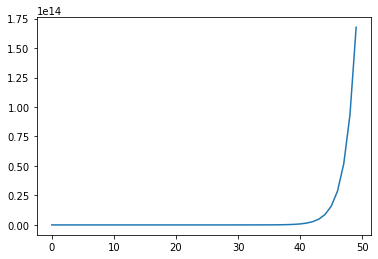

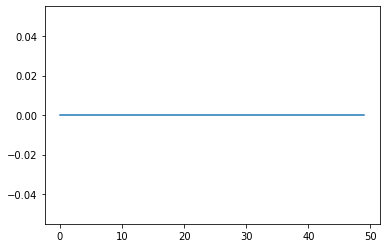

In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 0 -> 左
# 1 -> 下
# 2 -> 右
# 3 -> 上


#       3
#       ^
#       |
# 0< —— o —— > 2
#       |
#       v
#       1
# 动作空间=4，分别是上下左右移动，同时湖面上可能刮风，使agent随机移动

# S Starting point,safe
# F Frozen surface,safe
# H Hole,end of game,bad
# G Goal,end of game,good

# 状态空间=16,4x4的矩阵
# SFFF
# FHFH
# FFFH
# HFFG

# 在左侧边缘，无法向左移动，要么原地不动，要么向下移动
# 在上侧边缘，无法向上移动，要么原地不动，要么向右移动

# env = gym.make('FrozenLake-v0')
env = DrunkenWalkEnv(map_name="theAlley")
env.render()

        

def value_iteration(env, gamma = 0.9, no_of_iterations = 50):
    '''
    值迭代函数，目的是准确评估每一个状态的好坏
    '''
    # 状态价值函数，向量维度等于游戏状态的个数
#     print(env.observation_space.n)
#     print(env.action_space.n)
#     print(env.P)
    value_table = np.zeros(env.observation_space.n)
#     print()
    
    # 随着迭代，记录算法的收敛性
    error = [] # 价值函数的差
    index = [] # 价值函数的第一个元素
    
    threshold = 0.001
    
    for i in range(no_of_iterations):
#         print(i)
        updated_value_table = np.copy(value_table)
#         print(updated_value_table)
        for state in range(env.observation_space.n): # state = 0,1,2,3,...,12
            print("state", state)
            # 在某个状态下，采取4种动作后，分别的reward，Q_value长度=4
            Q_value = []
            
            for action in range(env.action_space.n): # action = 0,1,2,3
                # 采取不同action转移到不同的状态，也对应不同的reward
                next_states_rewards = []
                
                for next_sr in env.P[state][action]: # 在当前state和action的情况下，把可能转移的状态遍历一遍
#                     print("env.P", env.P)
#                     print("state, action", state, action)
                    # next_sr = (0.3333333333333333, 8,       0.0           , False)
                    # next_sr = (状态转移概率,        下一个状态,得到reward的概率,游戏是否结束)
                    trans_prob, next_state, reward_prob, _ = next_sr
#
                    print("trans, next_state, reward",trans_prob, next_state, reward_prob)
                    # 下一状态t的动作状态价值 = 转移到t状态的概率 × （ env反馈的reward + γ × t状态的当前价值 ）
                    next_states_rewards.append((trans_prob * (reward_prob + gamma * updated_value_table[next_state])))
                    print("next_states_rewards : ",next_states_rewards)
                # 将某一动作执行后，所有可能的t+1状态的价值加起来，就是在t状态采取a动作的价值 
                Q_value.append(np.sum(next_states_rewards))
                print("Q value", Q_value)
            # Q_value长度为4（上下左右）,选Q_value的最大值作为该状态的价值
            value_table[state] = max(Q_value)
            print("value table ",value_table)
        index.append(value_table[0])
        # 如果状态价值函数已经收敛 
        error.append(np.sum(np.fabs(updated_value_table - value_table)))
        if (np.sum(np.fabs(updated_value_table - value_table)) <= threshold):
            print ('Value-iteration converged at iteration# %d.' %(i+1))
            break
    # 画出价值函数的收敛曲线
    plt.figure(1)        
    plt.plot(error)   
    # 画出价值函数第一个元素的值的收敛情况
    plt.figure(2)
    plt.plot(index)
    return value_table

def extract_policy(value_table, gamma = 1.0):
    '''
    在一个收敛的、能够对状态进行准确评估的状态值函数的基础上，推导出策略函数，即在每一个状态下应该采取什么动作最优的
    '''
    
    # policy代表处于状态t时应该采取的最佳动作是上/下/左/右,policy长度16
    policy = np.zeros(env.observation_space.n)
    
    for state in range(env.observation_space.n):
        # 将价值迭代的过程再走一遍，但是不再更新value function，而是选出每个状态下对应最大价值的动作
        Q_table = np.zeros(env.action_space.n) # len=4
        for action in range(env.action_space.n):
            for next_sr in env.P[state][action]:
                # 
                trans_prob, next_state, reward_prob, _ = next_sr
                # 
                Q_table[action] += (trans_prob * (reward_prob + gamma * value_table[next_state]))
        # 选最优价值的动作
        policy[state] = np.argmax(Q_table)

    return policy

optimal_value_function = value_iteration(env=env)
print('\nthe best value function:\n',optimal_value_function,'\n')

optimal_policy = extract_policy(optimal_value_function, gamma=0.9)
print('the best policy:\n',optimal_policy)
